In [1]:
import docplex
import pandas as pd
import tensorflow as tf
import numpy as np
import utility
import copy
import mlp_explainer
import mymetrics
import time
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from milp import codify_network
from teste import get_minimal_explanation
from sklearn.metrics import classification_report
import pickle
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

In [2]:
# Load Dataset
dataset_name = 'Ionosphere' #Iris, Wine, Column, Pima, Parkinson, Breast_Cancer, Blood_Transfusion, Ionosphere, Glass, Climate, Modeling, Banknote, Sonar
result_path = f'{dataset_name}_results'
onestep_exps = np.load(f'{result_path}/onestep_explanations_0.25.npz')['onestep_explanations']
twostep_exps = np.load(f'{result_path}/twostep_explanations0.25.npz')['twostep_explanations']
loaded_bounds = np.load(f'bounds/{dataset_name}_data_bounds.npz')
original_bounds = loaded_bounds['original_bounds']
lower_bound, upper_bound = original_bounds[:, 0], original_bounds[:, 1]
print(original_bounds)
np.random.seed(50)

[[0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [3]:
d = 0.001
p_value = 0.25
num_instances=100
X_test = pd.read_csv(f'{dataset_name}_results/{dataset_name}_X_test.csv')
n_classes = len(X_test.target.unique())
classes = X_test.target.unique() #np.arange(n_classes)

In [4]:
onestep_coverages = []
twostep_coverages = []
for i, sample in enumerate(X_test.values[:,:-1]):
    artificial_lower_bounds = sample-d
    artificial_lower_bounds = np.maximum(artificial_lower_bounds, lower_bound)
    artificial_upper_bounds = sample+d
    artificial_upper_bounds = np.minimum(artificial_upper_bounds, upper_bound)
    data = np.random.uniform(low=artificial_lower_bounds, high=artificial_upper_bounds, size=(num_instances, len(sample)))
    df_artificial = pd.DataFrame(data, columns=X_test.columns[:-1])
    df_artificial.loc[len(df_artificial)] = sample
    #print(len(mymetrics.calculate_coverage(df_artificial,onestep_exps[i])),len(mymetrics.calculate_coverage(df_artificial,twostep_exps[i])))
    onestep_coverages.append(len(mymetrics.calculate_coverage(df_artificial,onestep_exps[i])))
    twostep_coverages.append(len(mymetrics.calculate_coverage(df_artificial,twostep_exps[i])))
    if onestep_coverages[-1] == 0:
        #print(f'Sample:{sample}\nExp: {onestep_exps[i]}')
        
        is_close_any = False  # Track if any `np.isclose()` is True
        for j, (s, (low, high)) in enumerate(zip(sample, onestep_exps[i])):
            close_low = np.isclose(s, low, atol=1e-15)
            close_high = np.isclose(s, high, atol=1e-15)
            if close_low or close_high:
                is_close_any = True  # If any match, flag it
        
        # If any value was close, increment the last element of onestep_coverages
        if is_close_any:
            print('Onestep Floating point error')
            onestep_coverages[-1] += 1
    if twostep_coverages[-1] == 0:
        #print(f'Sample:{sample}\nExp: {twostep_exps[i]}')
    
        is_close_any = False  # Reset flag for twostep
        for j, (s, (low, high)) in enumerate(zip(sample, twostep_exps[i])):
            close_low = np.isclose(s, low, atol=1e-15)
            close_high = np.isclose(s, high, atol=1e-15)
            if close_low or close_high:
                is_close_any = True  # If any match, flag it
    
        # If any value was close, increment the last element of twostep_coverages
        if is_close_any:
            print('Twostep Floating point error')
            twostep_coverages[-1] += 1

Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Twostep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Twostep Floating point error
Onestep Floating point error
Onestep Floating point error
Twostep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Twostep Floating point error
Onestep Floating point error
Twostep Floating point error
Onestep Floating point error
Twostep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floating point error
Onestep Floati

In [5]:
def compute_mean_std(arr):
    return np.mean(arr), np.std(arr)

def relative_percentage_diff(new, old):
    if np.any(old == 0):
        print(f'Warning: found possible division by zero')
        return np.where(old != 0, ((new - old) / old) * 100, np.nan)
    return ((new - old) / old) * 100
    
onestep_coverages = np.array(onestep_coverages)
twostep_coverages = np.array(twostep_coverages)

(coverage_mean_onestep, coverage_std_onestep) = compute_mean_std(onestep_coverages)
(coverage_mean_twostep, coverage_std_twostep) = compute_mean_std(twostep_coverages)

coverage_mean_diff = relative_percentage_diff(coverage_mean_twostep, coverage_mean_onestep)
coverage_std_diff = relative_percentage_diff(coverage_std_twostep, coverage_std_onestep)

coverage_relative_pointwise = relative_percentage_diff(twostep_coverages, onestep_coverages)
coverage_relative_mean = np.mean(coverage_relative_pointwise)
coverage_relative_std = np.std(coverage_relative_pointwise)

# Organize Data
all_metrics_data = {
    'Metric': ['Coverage'],
    'ONESTEP_MEAN': [coverage_mean_onestep],
    'ONESTEP_STD': [coverage_std_onestep],
    'TWOSTEP_MEAN': [coverage_mean_twostep],
    'TWOSTEP_STD': [coverage_std_twostep],
    'MEAN_DIFF_%': [coverage_mean_diff],
    'STD_DIFF_%': [coverage_std_diff],
    'POINTWISE_MEAN_%': [coverage_relative_mean],
    'POINTWISE_STD_%': [coverage_relative_std]
}
# Display and save
all_metrics_df = pd.DataFrame(all_metrics_data)
display(all_metrics_df)
all_metrics_df.to_csv(f'{dataset_name}_results/coverage_results_artificial_{p_value}.csv', index=False)

#Save Raw Metric Data
raw_df = pd.DataFrame({
    "coverage_onestep": onestep_coverages, 
    "coverage_twostep": twostep_coverages,
    "coverage_relative_%": coverage_relative_pointwise
})
raw_df.to_csv(f"{dataset_name}_results/coverage_raw_metric_data_{p_value}.csv", index=False)

C:\Users\Mateus\AppData\Local\Temp\ipykernel_7492\3998278764.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return np.where(old != 0, ((new - old) / old) * 100, np.nan)


,Metric,ONESTEP_MEAN,ONESTEP_STD,TWOSTEP_MEAN,TWOSTEP_STD,MEAN_DIFF_%,STD_DIFF_%,POINTWISE_MEAN_%,POINTWISE_STD_%
0,Coverage,1.0,0.0,2.94697,12.002723,194.69697,nan,194.69697,1200.272342


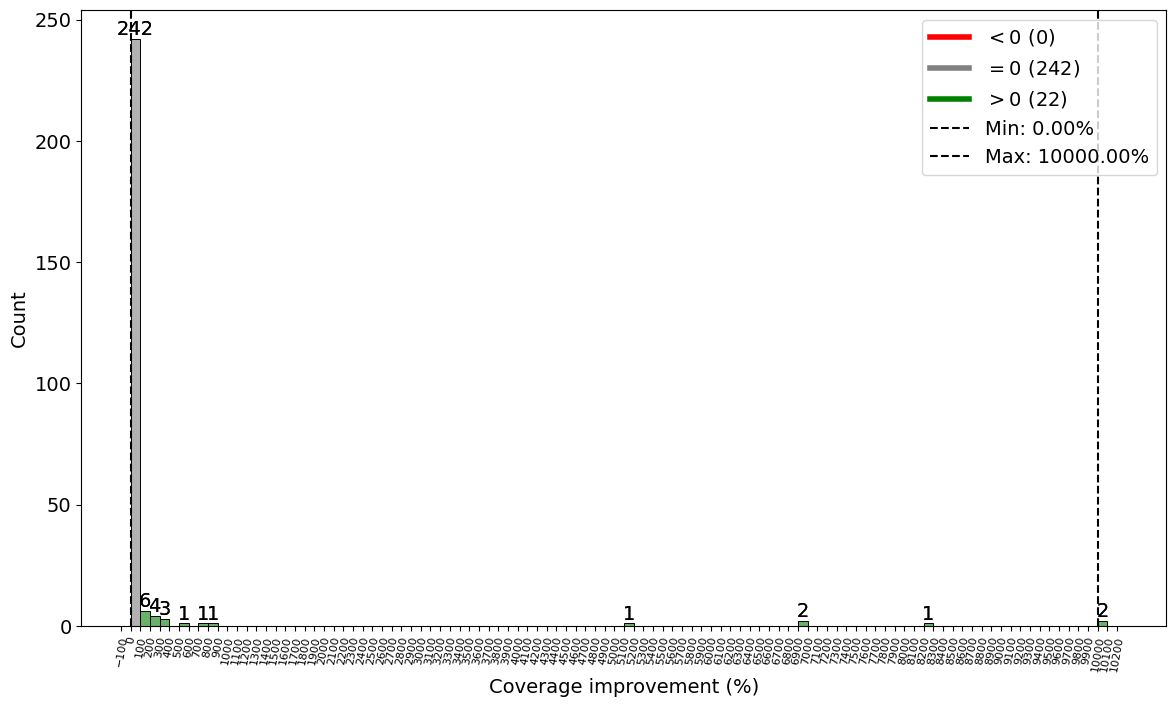

In [8]:
# Compute relative proportion
relative_proportion = np.where(
    raw_df['coverage_onestep'] != 0,
    ((raw_df['coverage_twostep'] - raw_df['coverage_onestep']) / raw_df['coverage_onestep']) * 100,
    np.nan
)

# Separate values
values_lt_0 = relative_proportion[relative_proportion < 0]
values_eq_0 = relative_proportion[relative_proportion == 0]
values_gt_0 = relative_proportion[relative_proportion > 0]

# Define bin width and edges
bin_width = 100
min_value = -bin_width if np.nanmin(relative_proportion) >= -bin_width else np.ceil(np.nanmin(relative_proportion) / -bin_width) * -bin_width
max_value = np.nanmax(relative_proportion) + bin_width

bin_edges_lt_0 = np.arange(min_value, bin_width+1, bin_width)  # Bins for < 0 values
bin_edges_gt_0 = np.arange(0, max_value+1+bin_width, bin_width)  # Bins for > 0 values

# Create figure
plt.figure(figsize=(14, 8))

# Plot histograms separately
ax_list = []
if len(values_lt_0) > 0:
    ax_lt_0 = sns.histplot(values_lt_0, bins=bin_edges_lt_0, kde=False, color='red', alpha=0.6, label=r'$ < 0$')
    ax_list.append(ax_lt_0)
if len(values_eq_0) > len(values_gt_0[values_gt_0<bin_width]):    
    ax_eq_0 = sns.histplot(values_eq_0, bins=bin_edges_gt_0, kde=False, color='gray', alpha=0.6, label=r'$ = 0$')
    ax_list.append(ax_eq_0)
else:
    ax_eq_0 = sns.histplot(values_eq_0, bins=bin_edges_gt_0, kde=False, color='gray', alpha=1, label=r'$ = 0$')
    ax_list.append(ax_eq_0)

if len(values_gt_0) > 0:
    ax_gt_0 = sns.histplot(values_gt_0, bins=bin_edges_gt_0, kde=False, color='green', alpha=0.6, label=r'$ > 0$')
    ax_list.append(ax_gt_0)

# Add numbers above each bin
for ax in ax_list:
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:
            plt.text(
                patch.get_x() + patch.get_width() / 2,  # Centered in bin
                height,  # Position above the bar
                f'{int(height)}',  # Rounded count
                ha='center', va='bottom', fontsize=14
            )



# Adjust xticks
xticks = np.arange(min_value, max_value+1+bin_width, bin_width)
plt.xticks(xticks, rotation=80,fontsize=8)
plt.yticks(fontsize=14)

# Find the y-position of the highest bar
max_height = max([patch.get_height() for patch in plt.gca().patches])

ax = plt.gca()  # Get current axis
ax.axvline(relative_proportion.min(), color='black', linestyle='--', label=f'Min: {relative_proportion.min():.2f}')
ax.axvline(relative_proportion.max(), color='black', linestyle='--', label=f'Max: {relative_proportion.max():.2f}')



# Labels and title
plt.ylabel('Count',fontsize=14)
plt.xlabel('Coverage improvement (%)',fontsize=14)
#plt.title(f'{dataset_title_name} - Elementwise coverage (%) comparison Twostep vs Onestep (n={len(raw_df)}, p={p})',fontsize=14)

# Correct legend
min_line = mlines.Line2D([], [], color='black', linestyle='--', label=f'Min: {relative_proportion.min():.2f}%')
max_line = mlines.Line2D([], [], color='black', linestyle='--', label=f'Max: {relative_proportion.max():.2f}%')

# Define existing legend handles
legend_handles = [
    plt.Line2D([0], [0], color='red', lw=4, label=rf'$ < 0$ ({len(values_lt_0)})'),
    plt.Line2D([0], [0], color='gray', lw=4, label=rf'$ = 0$ ({len(values_eq_0)})'),
    plt.Line2D([0], [0], color='green', lw=4, label=rf'$ > 0$ ({len(values_gt_0)})'),
    min_line,  # Add min line
    max_line   # Add max line
]

# Update the legend
plt.legend(handles=legend_handles, loc='upper right',fontsize=14)


#plt.savefig(f"{dataset_name}_results/{dataset_name}_artificial_coverage_{p}.eps", format='eps', dpi=300, bbox_inches='tight')
plt.savefig(f"relative_coverage/{dataset_name}_artificial_coverage_{p_value}.png", format='png', dpi=200, bbox_inches='tight')
plt.show()
